In [1]:
import warnings

# Coisa do Windows

# Ignorar o warning específico do KMeans
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
# Voltar ao normal
# warnings.filterwarnings("default")

# Trabalho Prático 1 de Ciência de Dados

Componentes do grupo:

- **Nome**: Alan Teixeira da Costa, **Matrícula**: 2022100890, **E-mail**: alan.costa@edu.ufes.br
- **Nome**: Arthur Esfanato Lopes, **Matrícula**: 2022100835, **E-mail**: arthur.e.lopes@edu.ufes.br
- **Nome**: Miguel Vieira Machado Pim, **Matrícula**: 2022100894, **E-mail**: miguel.pim@edu.ufes.br

## Imports

In [2]:
!pip install unidecode

In [3]:
import pandas as pd
import nltk
import string
import unidecode
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alanz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alanz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from numpy import linalg as LA
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_samples, silhouette_score

## Download e leitura

#### Download dos dados

In [5]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'id' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


#### Leitura dos dados

In [6]:
filmes_df = pd.read_csv("filmes.csv")
filmes_df.head()

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names
0,Family,7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston']
1,Romance,6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch']
2,Romance,6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker']
3,"Romance,Family",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer']
4,"Crime,Action",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann']


#### Distribuição dos gêneros

<Axes: xlabel='genres', ylabel='Count'>

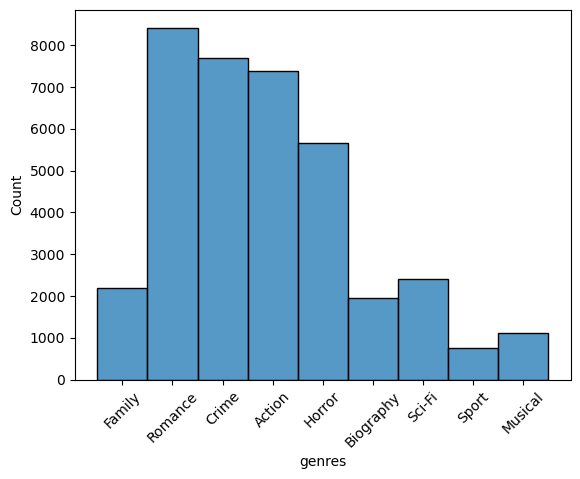

In [75]:
plt.xticks(rotation=45)
sns.histplot(filmes_df['genres'].apply(lambda x: x.split(sep=',')).explode('genres'))

## Pré-processamento dos dados

Para a parte de pré-processamento dos dados optamos por utilizar as técnicas passadas em aula pelo professor. Também testamos outras técnicas de pré-processamento, como o que já vem por padrão do ```TfidfVectorizer```. Também traduzimos as sinopses que não estavam na língua inglesa, que não surtiu muito efeito, pois são poucas sinopses que não estão em inglês e além disso, é muito custoso. Testamos também a biblioteca *spacy*. Como nenhuma dessas opções acima demonstraram alguma diferença nos resultados, optamos por continuar com o pré-processamento visto em aula.

#### Convertendo os tokens

Convertendo todos os tokens para letras minúsculas

In [7]:
def tokens_low(tokens):
  return [w.lower() for w in tokens]

Removendo os símbolos de pontuação

In [8]:
table = str.maketrans('', '', string.punctuation)

In [9]:
def tokens_pontuacao(tokens):
  return [w.translate(table) for w in tokens]

Convertendo carcteres especiais

In [10]:
def tokens_char_especical(tokens):
  return [unidecode.unidecode(w).lower() for w in tokens]

#### Filtrando apenas palavras

Extraindo apenas as palavras da lista de tokens

In [11]:
def tokens_apenas_words(tokens):
  return [word for word in tokens if word.isalpha()]

Removendo stop words

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
def tokens_stop_words(tokens):
  return [word for word in tokens if not word in stop_words]

#### Stemming

In [14]:
porter = PorterStemmer()

In [15]:
def tokens_stemming(tokens):
  return [porter.stem(word) for word in tokens]

#### Tokenizer Personalizado

In [16]:
def tokenizer_personalizado(texto):
  tokens = word_tokenize(texto)

  tokens = tokens_low(tokens)
  tokens = tokens_pontuacao(tokens)
  tokens = tokens_char_especical(tokens)
  tokens = tokens_apenas_words(tokens)
  tokens = tokens_stop_words(tokens)
  tokens = tokens_stemming(tokens)

  return tokens

## Configuração do Vectorizer - TF-IDF

Para o ```TfidfVectorizer``` utilizamos alguns parâmetros a mais: ***max_features***, ***max_df*** e ***ngram_range***.  
- ***max_features***: Restringe o vocabulário a um número específico $x$ de palavras, que são as $x$ palavras mais frequentes entre as sinopses. No nosso caso escolhemos $x = 3500$.
- ***max_df***: Elimina todas as palavras que aparecem em um percentual maior do $p$ das sinopses. No nosso caso $p = 0.8$, ou seja, as palavras que aparecem em mais de $80\%$ das sinopses são eliminadas.
- ***ngram_range***: Faz a junção de palavras compostas, por exemplo, "years old" são duas palavras mas que precisam estar juntas para ter o seu significado. Por isso, escolhemos o seu valor para ser $(1,2)$, para ele realizar essa junção para até duas palavras.

In [17]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer_personalizado, max_features=3500, max_df=0.8, ngram_range=(1,2))

## K-means

### Configuração dos Dados

Nossa abordagem para tratar os gêneros, foi de explodir as linhas, ou seja, um filme que tem múltiplos gêneros será multiplicado pela quantidade de gêneros que ele possui. Portanto, um filme com gênero *Romance,Action* será explodido em duas linhas, uma com o gênero *Romance*, e outra com o gênero *Action*, ambos com a mesma sinopse.

In [57]:
filmes_kmeans_df = filmes_df[['genres', 'sinopse']].copy()
filmes_kmeans_df['genres_list'] = filmes_kmeans_df['genres'].apply(lambda x: x.split(sep=','))
filmes_kmeans_df.head()

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,[Family]
1,Romance,John and Max resolve to save their beloved bai...,[Romance]
2,Romance,"Based on Terry McMillan's novel, this film fol...",[Romance]
3,"Romance,Family",George Banks must deal not only with his daugh...,"[Romance, Family]"
4,"Crime,Action",A group of high-end professional thieves start...,"[Crime, Action]"


In [58]:
# Filmes com mais de um genero foram multiplicados para que existam apenas um genero por filme
filmes_kmeans_df = filmes_kmeans_df.explode('genres_list')
filmes_kmeans_df.head()

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,Family
1,Romance,John and Max resolve to save their beloved bai...,Romance
2,Romance,"Based on Terry McMillan's novel, this film fol...",Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Family


### TF-IDF

In [20]:
X = vectorizer.fit_transform(filmes_kmeans_df['sinopse'])

c:\Users\alanz\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
matriz_tf_idf = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
matriz_tf_idf.head()

,abandon,abduct,abil,abl,aboard,abroad,abus,academi,accept,access,...,young son,young woman,young women,younger,younger brother,youngest,youngster,youth,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionalidade - SVD

Na redução de dimensionalidade foi utilizado o algoritmo SVD. Verificamos a curva da fração cumulativa da variância explicada para os $3500$ componentes dos dados, percebemos que poderiamos diminuir a dimensionalidade para $2500$ e ainda manter por volta de $90\%$ da variância dos dados. A redução foi feita em busca de simplificar a dimensionalidade dos dados sem uma perda significativa de informação.

In [59]:
svd = make_pipeline(TruncatedSVD(n_components=2500), Normalizer(copy=False))

In [60]:
svd.fit(X)

Pipeline(steps=[('truncatedsvd', TruncatedSVD(n_components=2500)),
                ('normalizer', Normalizer(copy=False))])

#### Curva - Fração Cumulativa da Variância Explicada

Text(0, 0.5, '$f(k)$ - Fração cumulativa da variância explicada')

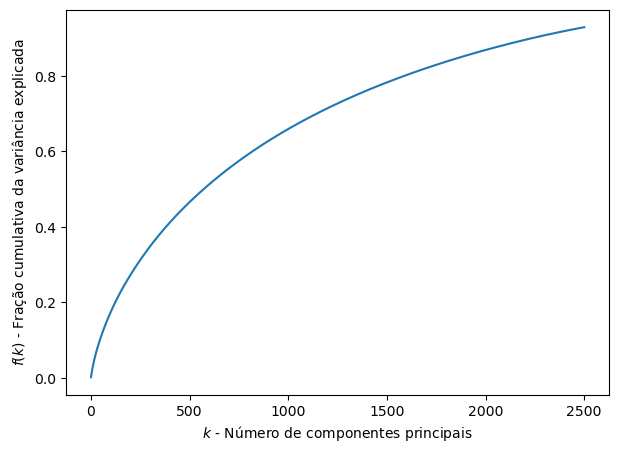

In [61]:
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, svd[0].n_components + 1)], np.cumsum(svd[0].explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')

In [62]:
X_REDUCED = svd.transform(X)

### Verificando o K-means - Escolha do K

Para a escolha do $K$ no *K-means*, primeiramente, tentamos recorrer à heurística do "joelho". Entretanto, como é possível observar na função objetivo para valores de $K$ entre $0$ e $100$, nenhum "joelho" aparece, e em nenhum $K$ apresentado o erro para de cair de maneira significativa. Como a função objetivo não nos deu muitas informações, buscamos usar o coeficiente de silhueta para alguns valores de $K$. Ao análisar vimos que os gráficos dos diferentes $Ks$ mantinham o mesmo padrão, assim escolhemos o valor de $K = 23$ por não ser um valor nem muito grande, nem muito pequeno que, talvez, faça o agrupamento perder o sentido, como o de ter muitos filmes em algum grupo e pouquíssimos em outros.

#### Função Objetivo

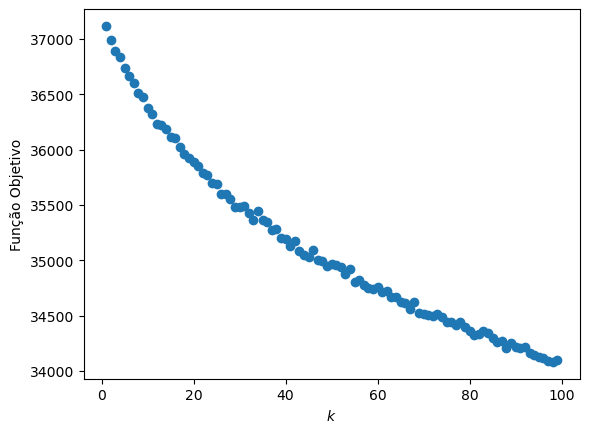

In [26]:
inertia = []
max_groups = 100
for i in range(1, max_groups):
  km = KMeans(n_clusters = i)
  km.fit(X_REDUCED)
  inertia.append(km.inertia_)

plt.scatter(range(1, max_groups), inertia)
_ = plt.ylabel("Função Objetivo")
_ = plt.xlabel(r"$k$")

#### Coeficiente de Silhueta

For n_clusters = 9 The average silhouette_score is : 0.004947075401773237
For n_clusters = 10 The average silhouette_score is : 0.00555516971395965
For n_clusters = 12 The average silhouette_score is : 0.006448145767648958
For n_clusters = 23 The average silhouette_score is : 0.009409218534250275
For n_clusters = 40 The average silhouette_score is : 0.012623952341090995


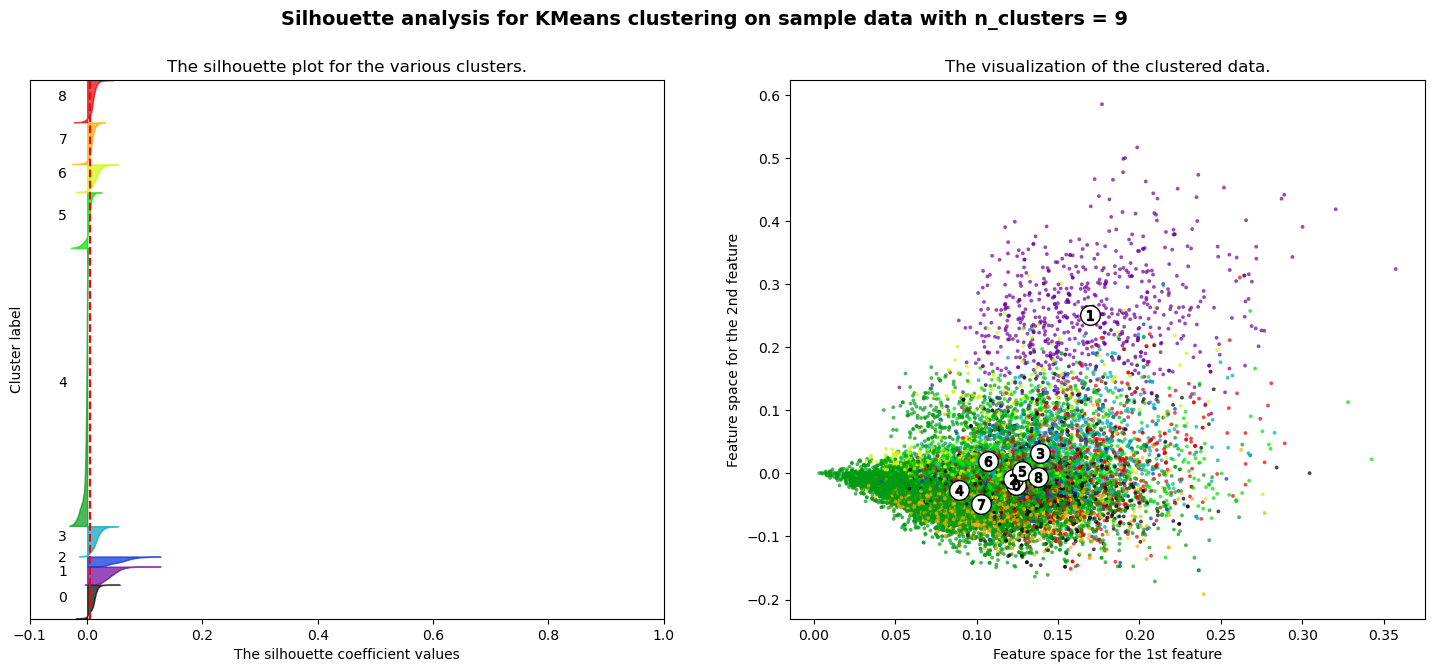

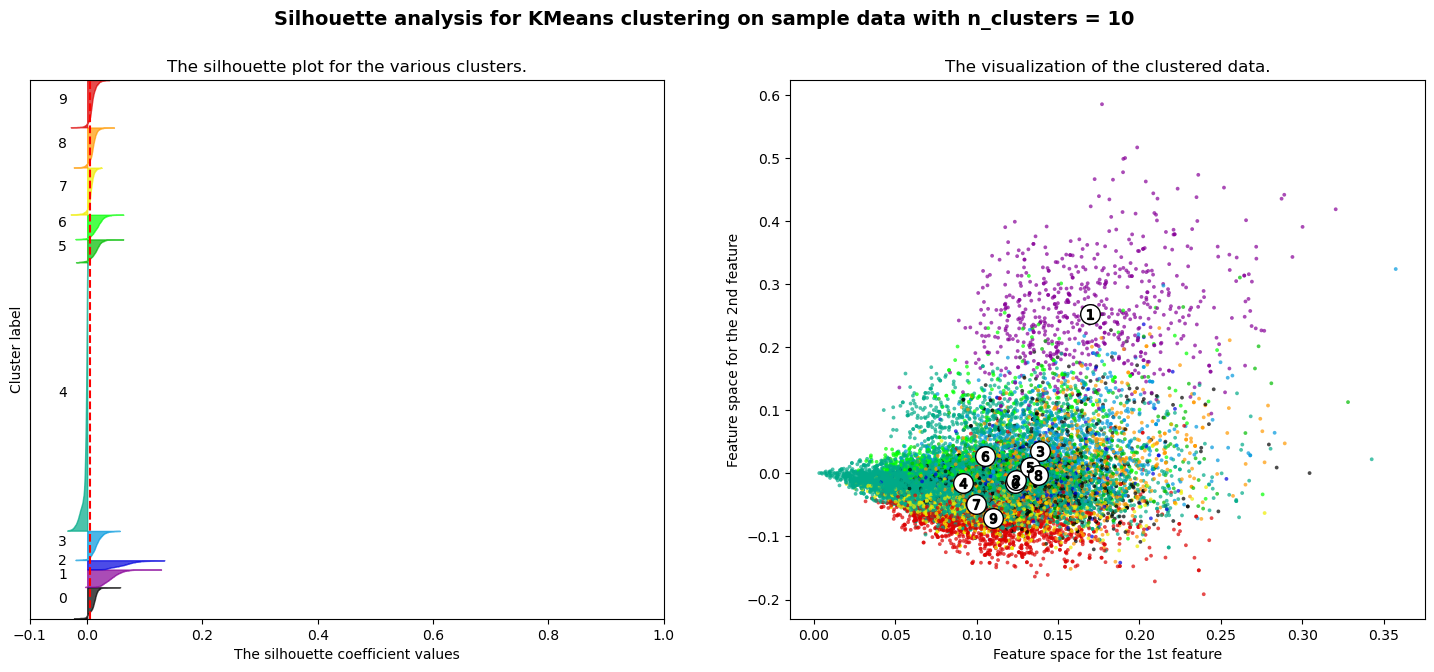

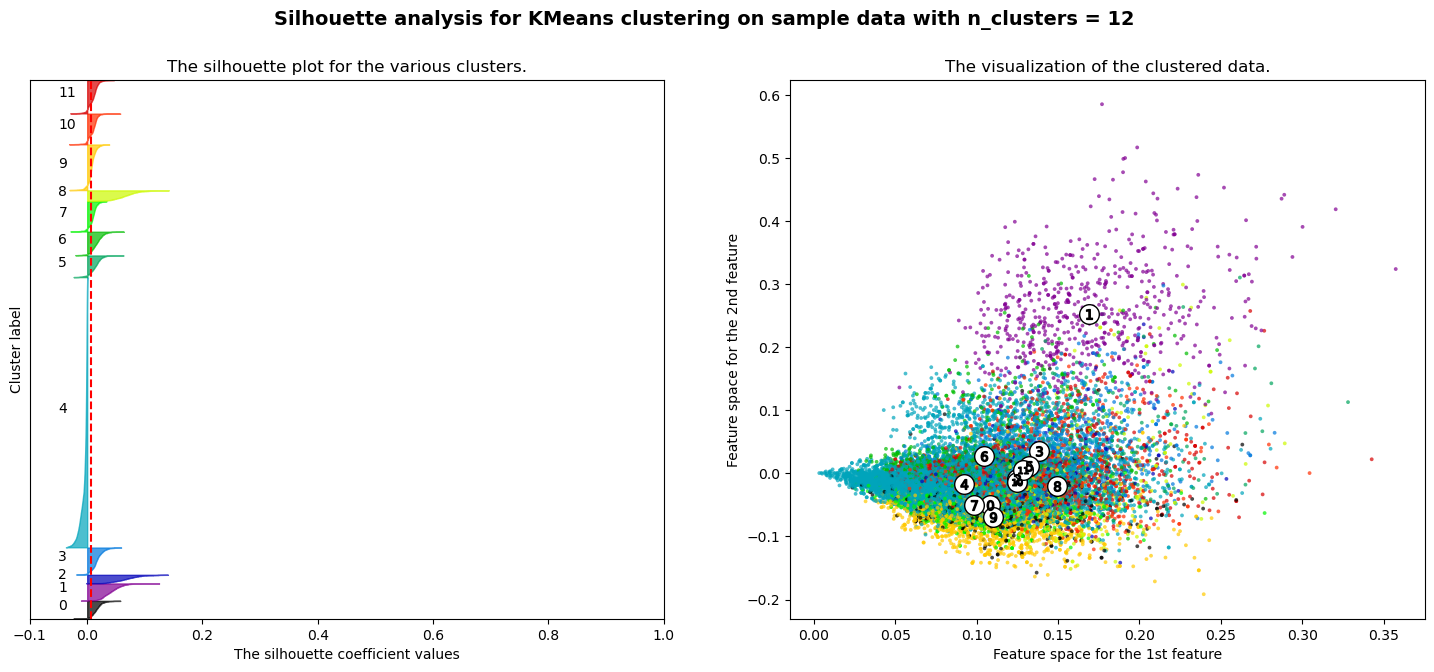

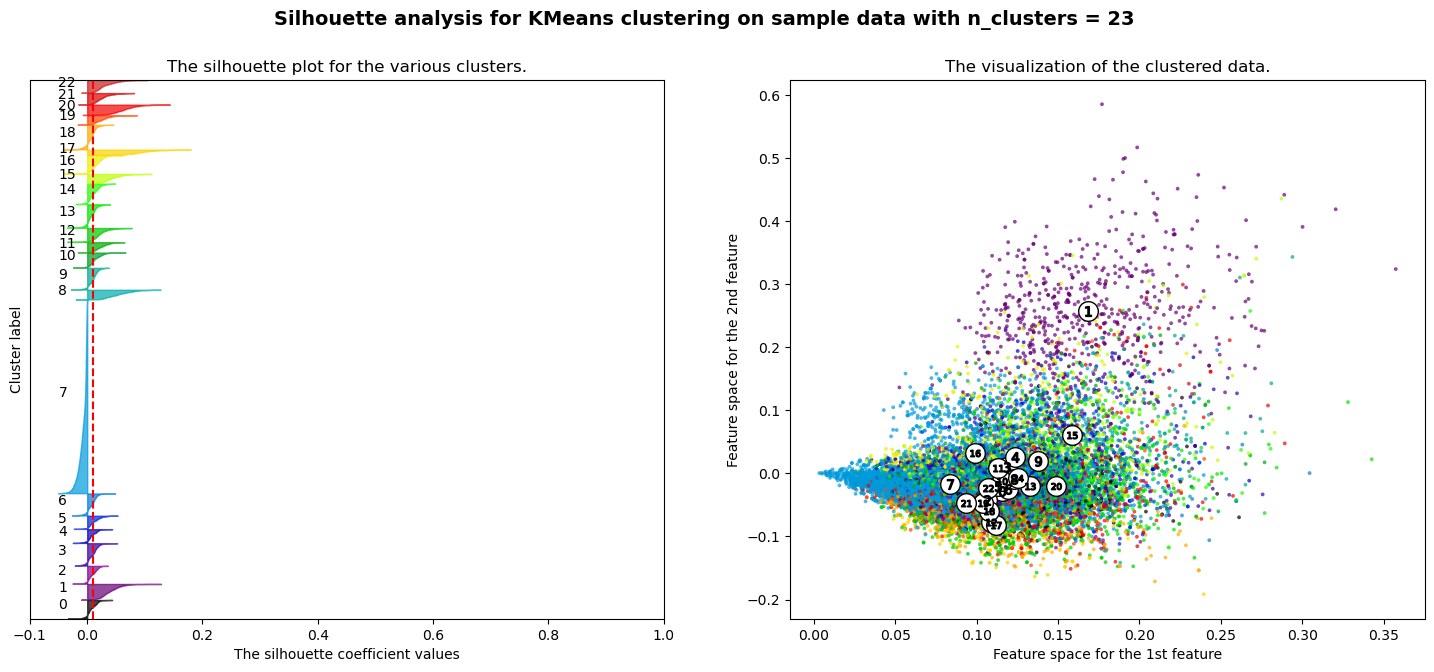

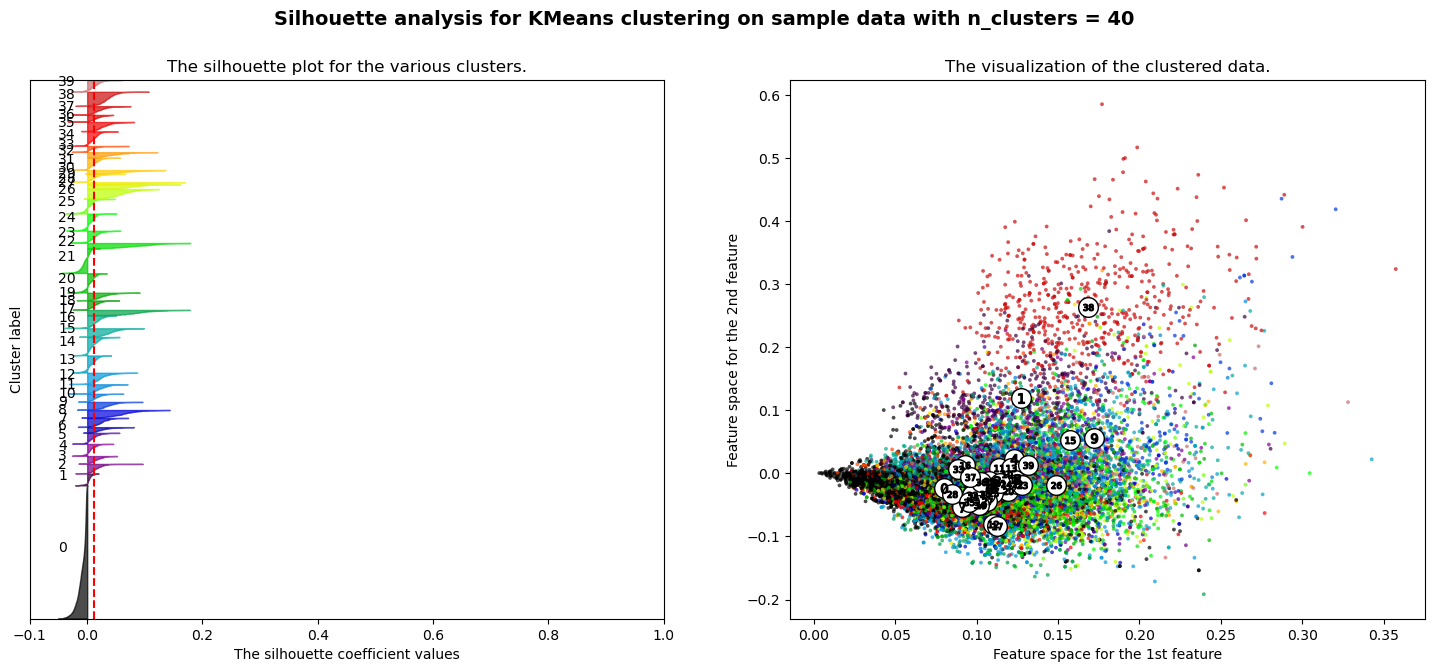

In [63]:
X_DENSE = X_REDUCED

range_n_clusters = [9, 10, 12, 23, 40]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_DENSE) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_DENSE)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_DENSE, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_DENSE, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_DENSE[:, 0], X_DENSE[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

### Agrupando

In [28]:
k_groups = 23
kmeans = KMeans(n_clusters = k_groups)
kmeans.fit(X_REDUCED)
y_kmeans = kmeans.predict(X_REDUCED)

### Análise dos Grupos

Os gráficos aqui apresentados foram utilizados para realizar a análise descrita no final no arquivo.

#### Atribuindo os Grupos

In [29]:
filmes_kmeans_df['grupos'] = y_kmeans

#### Matriz Generos X Grupos

In [30]:
generosXgrupos = filmes_kmeans_df.groupby(['genres_list', 'grupos']).size().unstack(fill_value=0)
generosXgrupos

grupos,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,142,203,444,97,3062,322,116,350,279,171,...,122,104,64,259,497,125,91,136,335,92
Biography,33,26,21,28,895,6,33,58,90,21,...,52,11,19,347,66,26,34,9,34,60
Crime,270,305,805,191,2690,338,187,431,86,194,...,279,24,74,343,91,118,96,158,421,111
Family,30,14,7,36,899,26,161,73,32,62,...,28,16,43,116,106,246,25,59,108,30
Horror,305,55,151,46,2181,52,253,274,48,160,...,169,181,71,186,228,95,40,226,194,59
Musical,27,5,10,38,478,4,70,46,22,30,...,26,5,14,51,23,19,81,27,75,20
Romance,588,52,54,210,2874,36,421,495,198,208,...,344,32,169,556,123,160,740,148,449,143
Sci-Fi,52,30,54,20,789,18,36,124,44,50,...,27,227,20,98,519,31,11,66,62,25
Sport,9,9,1,8,348,7,16,21,9,14,...,4,1,46,60,45,27,9,18,46,15


**Grupos ordenados em ordem decrescente em relação à quantidade de filmes nos grupos**

In [31]:
generosXgrupos = generosXgrupos[generosXgrupos.sum().sort_values(ascending=False).index]
generosXgrupos

grupos,4,16,7,21,17,2,0,6,19,10,...,18,12,5,8,1,3,14,22,15,11
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,3062,259,350,335,497,444,142,116,91,96,...,125,232,322,279,203,97,104,92,64,42
Biography,895,347,58,34,66,21,33,33,34,19,...,26,59,6,90,26,28,11,60,19,9
Crime,2690,343,431,421,91,805,270,187,96,148,...,118,163,338,86,305,191,24,111,74,167
Family,899,116,73,108,106,7,30,161,25,46,...,246,19,26,32,14,36,16,30,43,0
Horror,2181,186,274,194,228,151,305,253,40,418,...,95,108,52,48,55,46,181,59,71,152
Musical,478,51,46,75,23,10,27,70,81,22,...,19,28,4,22,5,38,5,20,14,0
Romance,2874,556,495,449,123,54,588,421,740,241,...,160,173,36,198,52,210,32,143,169,8
Sci-Fi,789,98,124,62,519,54,52,36,11,56,...,31,36,18,44,30,20,227,25,20,10
Sport,348,60,21,46,45,1,9,16,9,25,...,27,14,7,9,9,8,1,15,46,1


**Mapa de Calor Geral - Figura 1**

<Axes: xlabel='grupos', ylabel='genres_list'>

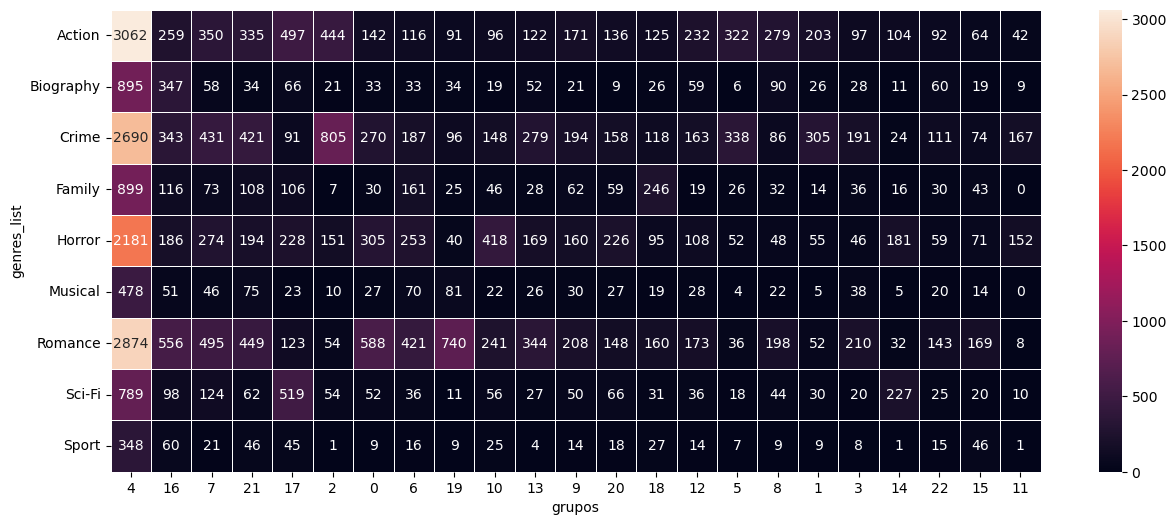

In [32]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generosXgrupos, annot=True, fmt="d", linewidths=0.5, ax=ax)

**Mapa de Calor Colunas Normalizadas - Figura 2**

In [33]:
# Normalizando os valores das colunas
generos_norm = generosXgrupos.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
generos_norm

grupos,4,16,7,21,17,2,0,6,19,10,...,18,12,5,8,1,3,14,22,15,11
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,1.000000,0.411881,0.694093,0.725301,0.955645,0.550995,0.229706,0.246914,0.112175,0.192982,...,0.466960,1.000000,0.952096,1.000000,0.660000,0.440594,0.455752,0.601562,0.322581,0.251497
Biography,0.201548,0.586139,0.078059,0.000000,0.086694,0.024876,0.041451,0.041975,0.034200,0.000000,...,0.030837,0.206422,0.005988,0.300000,0.070000,0.099010,0.044248,0.351562,0.032258,0.053892
Crime,0.862933,0.578218,0.864979,0.932530,0.137097,1.000000,0.450777,0.422222,0.119015,0.323308,...,0.436123,0.683486,1.000000,0.285185,1.000000,0.905941,0.101770,0.750000,0.387097,1.000000
Family,0.203021,0.128713,0.109705,0.178313,0.167339,0.007463,0.036269,0.358025,0.021888,0.067669,...,1.000000,0.022936,0.065868,0.085185,0.030000,0.138614,0.066372,0.117188,0.187097,0.000000
Horror,0.675387,0.267327,0.533755,0.385542,0.413306,0.186567,0.511226,0.585185,0.042408,1.000000,...,0.334802,0.431193,0.143713,0.144444,0.166667,0.188119,0.796460,0.343750,0.367742,0.910180
Musical,0.047900,0.000000,0.052743,0.098795,0.000000,0.011194,0.031088,0.133333,0.098495,0.007519,...,0.000000,0.064220,0.000000,0.048148,0.000000,0.148515,0.017699,0.039062,0.000000,0.000000
Romance,0.930730,1.000000,1.000000,1.000000,0.201613,0.065920,1.000000,1.000000,1.000000,0.556391,...,0.621145,0.729358,0.095808,0.700000,0.156667,1.000000,0.137168,1.000000,1.000000,0.047904
Sci-Fi,0.162491,0.093069,0.217300,0.067470,1.000000,0.065920,0.074266,0.049383,0.002736,0.092732,...,0.052863,0.100917,0.041916,0.129630,0.083333,0.059406,1.000000,0.078125,0.038710,0.059880
Sport,0.000000,0.017822,0.000000,0.028916,0.044355,0.000000,0.000000,0.000000,0.000000,0.015038,...,0.035242,0.000000,0.008982,0.000000,0.013333,0.000000,0.000000,0.000000,0.206452,0.005988


<Axes: xlabel='grupos', ylabel='genres_list'>

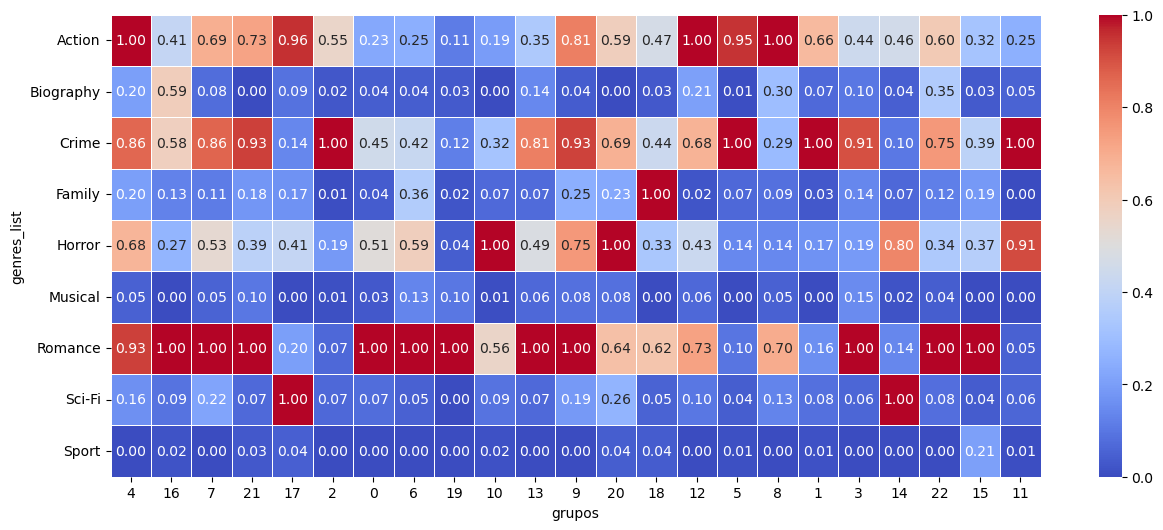

In [34]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_norm, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

**Mapa de Calor Porcentagem de Generos nos Grupos - Figura 3**

In [35]:
generos_por = generosXgrupos.apply(lambda x: x / x.sum())
generos_por

grupos,4,16,7,21,17,2,0,6,19,10,...,18,12,5,8,1,3,14,22,15,11
genres_list,,,,,,,,,,,,,,,,,,,,,
Action,0.215391,0.128472,0.186966,0.194316,0.292697,0.287007,0.097527,0.089714,0.080745,0.089636,...,0.147580,0.278846,0.398022,0.345297,0.290415,0.143917,0.173045,0.165766,0.123077,0.107969
Biography,0.062957,0.172123,0.030983,0.019722,0.038869,0.013575,0.022665,0.025522,0.030169,0.017740,...,0.030697,0.070913,0.007417,0.111386,0.037196,0.041543,0.018303,0.108108,0.036538,0.023136
Crime,0.189223,0.170139,0.230235,0.244200,0.053592,0.520362,0.185440,0.144625,0.085182,0.138189,...,0.139315,0.195913,0.417800,0.106436,0.436338,0.283383,0.039933,0.200000,0.142308,0.429306
Family,0.063239,0.057540,0.038996,0.062645,0.062426,0.004525,0.020604,0.124517,0.022183,0.042951,...,0.290437,0.022837,0.032138,0.039604,0.020029,0.053412,0.026622,0.054054,0.082692,0.000000
Horror,0.153419,0.092262,0.146368,0.112529,0.134276,0.097608,0.209478,0.195669,0.035492,0.390289,...,0.112161,0.129808,0.064277,0.059406,0.078684,0.068249,0.301165,0.106306,0.136538,0.390746
Musical,0.033624,0.025298,0.024573,0.043503,0.013545,0.006464,0.018544,0.054138,0.071872,0.020542,...,0.022432,0.033654,0.004944,0.027228,0.007153,0.056380,0.008319,0.036036,0.026923,0.000000
Romance,0.202167,0.275794,0.264423,0.260441,0.072438,0.034906,0.403846,0.325599,0.656610,0.225023,...,0.188902,0.207933,0.044499,0.245050,0.074392,0.311573,0.053245,0.257658,0.325000,0.020566
Sci-Fi,0.055501,0.048611,0.066239,0.035963,0.305654,0.034906,0.035714,0.027842,0.009760,0.052288,...,0.036600,0.043269,0.022250,0.054455,0.042918,0.029674,0.377704,0.045045,0.038462,0.025707
Sport,0.024479,0.029762,0.011218,0.026682,0.026502,0.000646,0.006181,0.012374,0.007986,0.023343,...,0.031877,0.016827,0.008653,0.011139,0.012876,0.011869,0.001664,0.027027,0.088462,0.002571


<Axes: xlabel='grupos', ylabel='genres_list'>

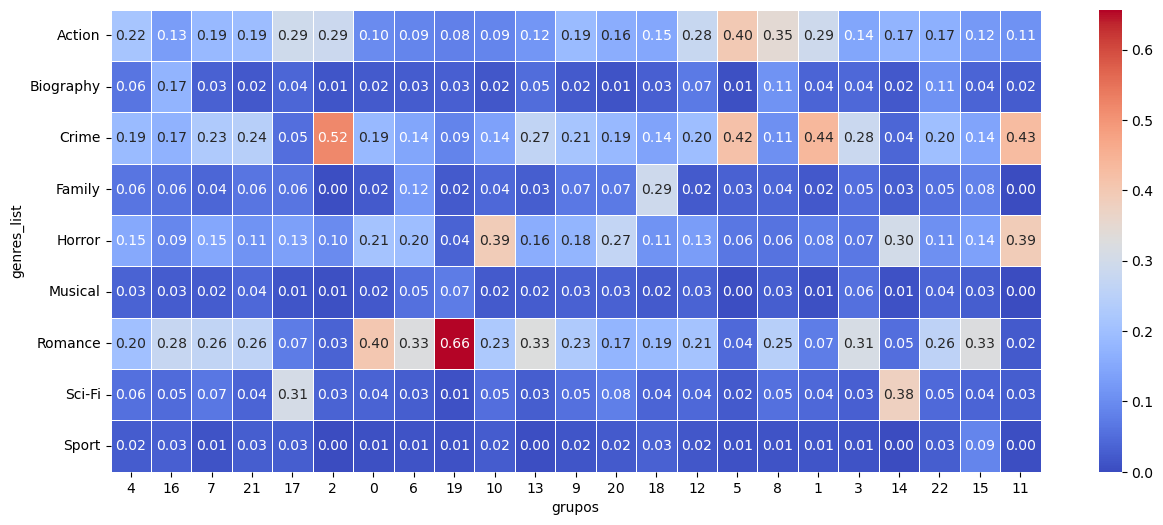

In [36]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_por, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

## Agrupamento Espectral

### Configuração dos Dados

Nossa abordagem para tratar os gêneros do agrupamento espectral foi a mesma usada para o k-means.

In [37]:
filmes_espec_df = filmes_df[['genres', 'sinopse']].copy()
filmes_espec_df['genres_list'] = filmes_espec_df['genres'].apply(lambda x: x.split(sep=','))
filmes_espec_df.head()

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,[Family]
1,Romance,John and Max resolve to save their beloved bai...,[Romance]
2,Romance,"Based on Terry McMillan's novel, this film fol...",[Romance]
3,"Romance,Family",George Banks must deal not only with his daugh...,"[Romance, Family]"
4,"Crime,Action",A group of high-end professional thieves start...,"[Crime, Action]"


In [38]:
# Filmes com mais de um genero foram multiplicados para que existam apenas um genero por filme
filmes_espec_df = filmes_espec_df.explode('genres_list')
filmes_espec_df.head()

,genres,sinopse,genres_list
0,Family,When two kids find and play a magical board ga...,Family
1,Romance,John and Max resolve to save their beloved bai...,Romance
2,Romance,"Based on Terry McMillan's novel, this film fol...",Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Romance
3,"Romance,Family",George Banks must deal not only with his daugh...,Family


**Amostra Aleatória - 20000**

Para o agrupamento espectral utilizamos uma sample $n = 20000$ dos dados, pois ele demanda um custo computacional maior que o do k-means.

In [39]:
# Amostra aleatória
filmes_espec_df = filmes_espec_df.sample(n=20000)
filmes_espec_df.head()

,genres,sinopse,genres_list
8922,Biography,The last days of life of the legendary Polish ...,Biography
26910,"Crime,Action",Bad City is on the edge of falling into the ha...,Crime
7044,"Sport,Romance",When her brother decides to ditch for a couple...,Romance
20976,Family,A young boy befriends an orphaned cub and rais...,Family
27077,"Crime,Sci-Fi,Horror",A pair of hard-boiled Tokyo cops are investiga...,Horror


### TF-IDF

In [40]:
X = vectorizer.fit_transform(filmes_espec_df['sinopse'])

c:\Users\alanz\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [41]:
matriz_tf_idf = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
matriz_tf_idf.head()

,abandon,abduct,abil,abl,aboard,abroad,abus,academi,accept,accid,...,young son,young woman,young women,younger,younger brother,youngster,youth,zombi,zombi apocalyps,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionalidade - SVD

Para a redução de dimensionalidade do agrupamento espectral escolhemos $n\_componets = 2250$, pois como usamos uma sample de $n = 20000$, para alcançarmos $90\%$ de variância acumulada dos dados, teremos que ter $2250$ colunas na matriz reduzida.

In [42]:
svd = make_pipeline(TruncatedSVD(n_components=2250), Normalizer(copy=False))

In [43]:
svd.fit(X)

Pipeline(steps=[('truncatedsvd', TruncatedSVD(n_components=2250)),
                ('normalizer', Normalizer(copy=False))])

#### Curva - Fração Cumulativa da Variância Explicada

Text(0, 0.5, '$f(k)$ - Fração cumulativa da variância explicada')

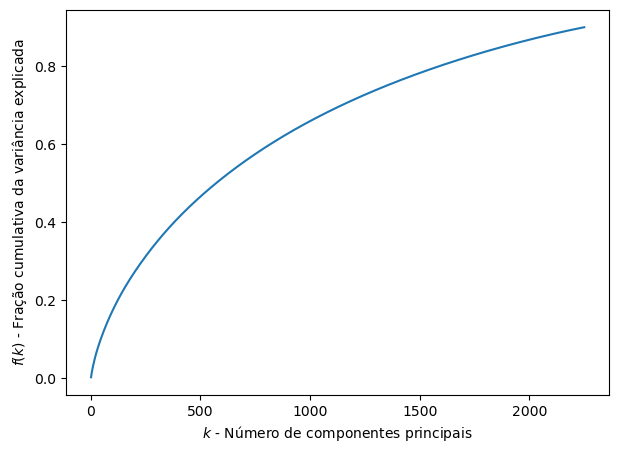

In [44]:
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, svd[0].n_components + 1)], np.cumsum(svd[0].explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')

In [45]:
X_REDUCED = svd.transform(X)

### Verificando Algorimo Espectral - Escolha do K

Para a escolha do $K$ no algoritmo espectral, usamos a medida eigengap, que, por sua vez, indicou que uma boa escolha de $K$ seria 2 ou 3. Como esses valores foram muito baixos decidimos um $K$ igual a 6, para uma melhor comparação entre grupos. Vale ressaltar que vários valores de $K$ foram testados, mas as distribuições entre os grupos se mantinham a mesma.

Text(0, 0.5, 'Autovalor')

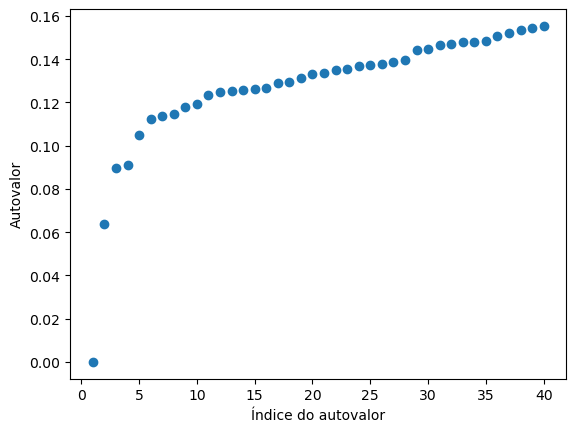

In [46]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from numpy import linalg as LA

# 1 Construindo a matriz de adjacências do grafo de vizinhos mais próximos.
G = kneighbors_graph(X_REDUCED, n_neighbors = 10, include_self = True)
A = 0.5 * (G + G.T)

# 2 Construindo a Laplaciana Normalizada
L = csgraph.laplacian(A, normed = True).todense()

# 3 Obtendo os autovalores da Laplaciana Normalizada
# Valores já estão ordenados em ordem crescente.
values, _ = LA.eigh(L)

# 4 Plotando os valores dos 'gaps' e escolhendo um k adequado.
plt.scatter([i for i in range(1, 41)], values[:40])
plt.xlabel('Índice do autovalor')
plt.ylabel('Autovalor')

### Agrupando

In [48]:
k_group = 6
m = SpectralClustering(n_clusters = k_group, affinity = 'nearest_neighbors', n_neighbors = 10)
m.fit(X_REDUCED)

SpectralClustering(affinity='nearest_neighbors', n_clusters=6)

### Análise dos Grupos

Os gráficos aqui apresentados foram utilizados para realizar a análise descrita no final no arquivo.

#### Atribuindo os Grupos

In [49]:
filmes_espec_df['grupos'] = m.labels_

#### Matriz Generos X Grupos

In [50]:
generosXgrupos = filmes_espec_df.groupby(['genres_list', 'grupos']).size().unstack(fill_value=0)
generosXgrupos

grupos,0,1,2,3,4,5
genres_list,,,,,,
Action,3891,9,0,2,1,8
Biography,1038,1,0,0,0,0
Crime,4126,24,8,12,3,16
Family,1183,1,0,1,4,0
Horror,2940,6,2,3,12,9
Musical,585,3,0,0,0,1
Romance,4459,9,6,0,4,5
Sci-Fi,1208,3,1,0,5,2
Sport,409,0,0,0,0,0


**Grupos ordenados em ordem decrescente em relação à quantidade de filmes no grupos**

In [51]:
generosXgrupos = generosXgrupos[generosXgrupos.sum().sort_values(ascending=False).index]
generosXgrupos

grupos,0,1,5,4,3,2
genres_list,,,,,,
Action,3891,9,8,1,2,0
Biography,1038,1,0,0,0,0
Crime,4126,24,16,3,12,8
Family,1183,1,0,4,1,0
Horror,2940,6,9,12,3,2
Musical,585,3,1,0,0,0
Romance,4459,9,5,4,0,6
Sci-Fi,1208,3,2,5,0,1
Sport,409,0,0,0,0,0


**Mapa de Calor Geral - Figura 1**

<Axes: xlabel='grupos', ylabel='genres_list'>

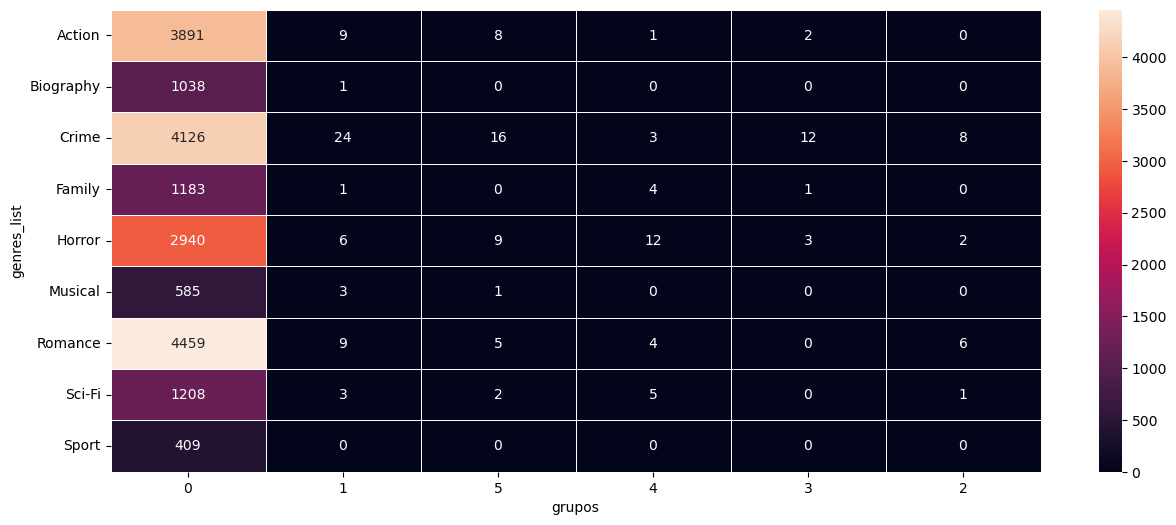

In [52]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generosXgrupos, annot=True, fmt="d", linewidths=0.5, ax=ax)

**Mapa de Calor Colunas Normalizadas - Figura 2**

In [53]:
# Normalizando os valores das colunas
generos_norm = generosXgrupos.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
generos_norm

grupos,0,1,5,4,3,2
genres_list,,,,,,
Action,0.859753,0.375000,0.5000,0.083333,0.166667,0.000
Biography,0.155309,0.041667,0.0000,0.000000,0.000000,0.000
Crime,0.917778,1.000000,1.0000,0.250000,1.000000,1.000
Family,0.191111,0.041667,0.0000,0.333333,0.083333,0.000
Horror,0.624938,0.250000,0.5625,1.000000,0.250000,0.250
Musical,0.043457,0.125000,0.0625,0.000000,0.000000,0.000
Romance,1.000000,0.375000,0.3125,0.333333,0.000000,0.750
Sci-Fi,0.197284,0.125000,0.1250,0.416667,0.000000,0.125
Sport,0.000000,0.000000,0.0000,0.000000,0.000000,0.000


<Axes: xlabel='grupos', ylabel='genres_list'>

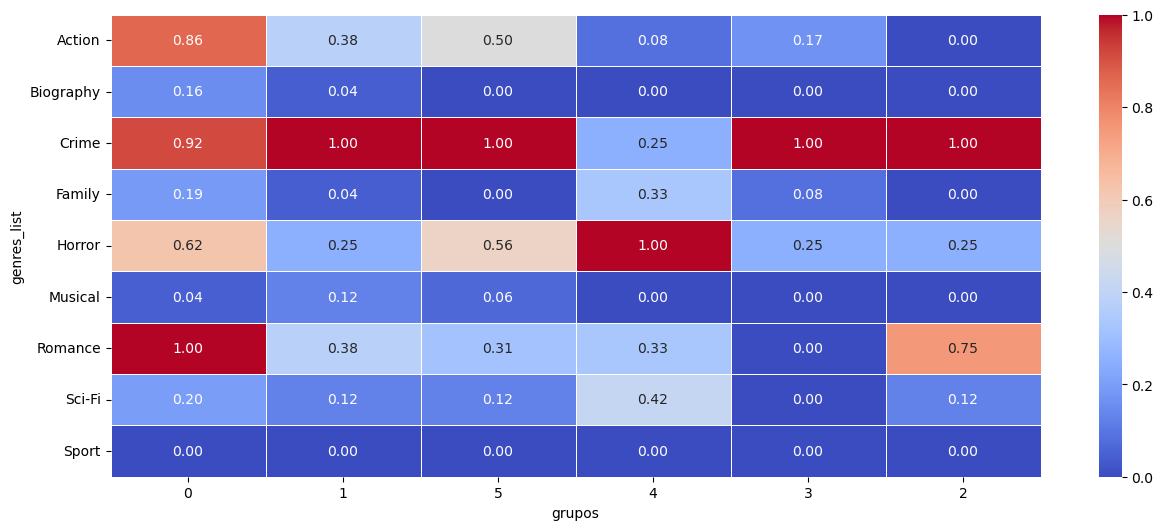

In [54]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_norm, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

**Mapa de Calor Porcentagem de Generos nos Grupos - Figura 3**

In [55]:
generos_por = generosXgrupos.apply(lambda x: x / x.sum())
generos_por

grupos,0,1,5,4,3,2
genres_list,,,,,,
Action,0.196129,0.160714,0.195122,0.034483,0.111111,0.000000
Biography,0.052321,0.017857,0.000000,0.000000,0.000000,0.000000
Crime,0.207974,0.428571,0.390244,0.103448,0.666667,0.470588
Family,0.059630,0.017857,0.000000,0.137931,0.055556,0.000000
Horror,0.148193,0.107143,0.219512,0.413793,0.166667,0.117647
Musical,0.029487,0.053571,0.024390,0.000000,0.000000,0.000000
Romance,0.224759,0.160714,0.121951,0.137931,0.000000,0.352941
Sci-Fi,0.060890,0.053571,0.048780,0.172414,0.000000,0.058824
Sport,0.020616,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: xlabel='grupos', ylabel='genres_list'>

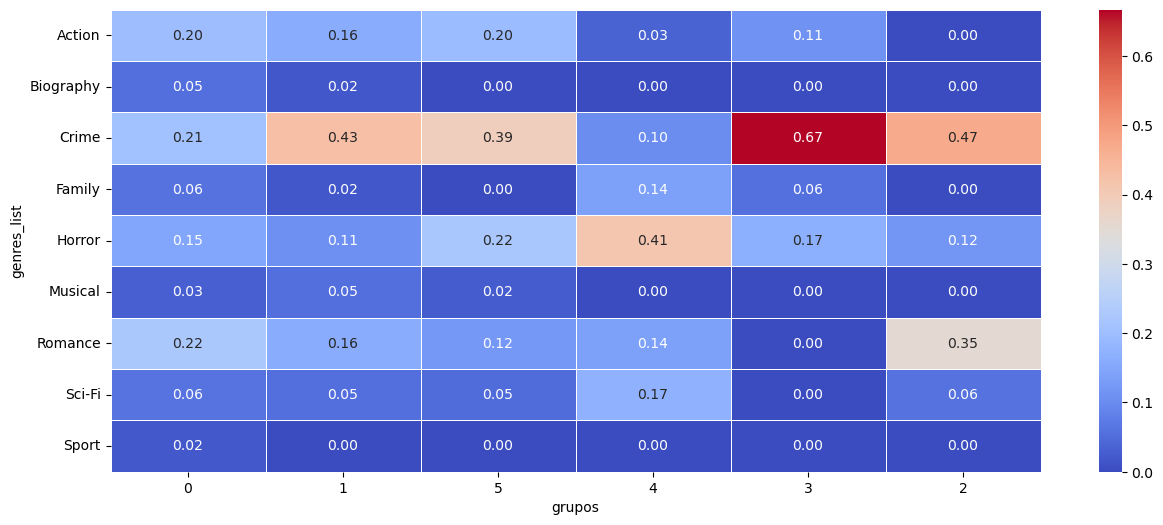

In [56]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(generos_por, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, ax=ax)

## Validação da Metodologia

Muitas das questões da validação da metodologia foram respondidas ao longo do trabalho, como: Escolha do número de componentes no SVD e a escolha do número de grupos para os agrupamentos. Agora trataremos do restantes das perguntas a serem respondidas sobre a validação da metodologia.

1. Com os nossos testes o número de componentes principais do SVD não trouxe um impacto significativo para os resultados, nossa escolha acabou sendo totalmente baseada na variância acumulada. Com isso, também podemos concluir que para os resulados SVD não é estritamente necessário, pois o parâmetro ***max_features*** do ```TfidfVectorizer``` já nos dá uma matriz com menos componentes, e mesmo testando apenas essa matriz, os resultados não foram impactados.
2. A escolha do agrupamento não trouxe um impacto que esperavámos nos resultados, o *K-means* consegue separar um pouco mais os grupos, enquanto o *espectral* acumula muito mais filmes em um único grupo. E a escolha do valor de $K$ nos agrupamento também não gerou impacto significativo nos resultados, uma vez que, sempre obtinhamos um grupo muito mais denso que os demais.

## Análise

Agora iremos responder as perguntas:  
- Há diferença nas distribuições de gêneros dos filmes em grupos diferentes?
- Há relação entre as sinopses dos filmes e os respectivos gêneros?

Respostas:  
1. Sim, há uma diferença nas distribuições de gêneros de filmes em grupos diferentes. Mesmo com um dos grupos muito mais denso que os demais, ao analisarmos o terceiro mapa de calor para ambos os agrupamentos, podemos observar que em alguns grupos específicos existe uma predominância de algum dos gêneros. Vale ressaltar que o grupo que contêm a maior quantidade de filmes possui uma distribuição de gêneros mais uniforme, que vai de acordo com a distribuição de gêneros dos dados em si. 

2. Podemos concluir com todas essas análises que, na maioria dos casos, existe pouquíssima relação entre as sinopses dos filmes e seus respectivos gêneros, mas podemos inferir que existem muitas sinopses padrões/genéricas, dado que sempre temos um grupo com muitos gêneros e distribuidos de forma uniforme. Também podemos concluir que alguns tipos de sinopses podem nos indicar o gênero daquele filme, uma vez que alguns dos grupos tiveram uma predominancia de algum gênero em específico. Um exemplo disso é o grupo $14$ do *K-means* que possui muitos filmes do gênero *Sci-Fi*, que, por sua vez, é um gênero que pouco aparece nos dados, portanto esse grupo não vai de acordo com o padrão de distribuição de gênero dos dados. Além disso, pelo *K-means*, por ter conseguido separar melhor os grupos, é possível observar que, talvez, tenha maior semelhança entre sinopses de alguns gêneros, por exemplo, *Action* e *Crime* compartilham com intensidade considerável os grupos $2$, $1$ e $5$, isso fica evidente ao visualizar o mapa de calor normalizado do *K-means*.